# Tutorial | Simple pendulum

###### *example taken from [Arby](https://arby.readthedocs.io/en/latest/)

In this example we will build a reduced model for a simple pendulum using Scikit-ReducedModel. 

This system can be described by the ordinary differential equation (ODE)

\begin{equation}
\ddot{\theta} = -b\dot{\theta} - \frac{g}{l} \sin{\theta}
\end{equation}

where $g, l$ denote the gravity strenght and the pendulum longitude, respectively. The parameter $b$ is the damping factor.

We can decompose the 2nd order ODE above in two 1st order ODEs leading to the
desired pendulum equations

\begin{align}
\dot{\theta} &= \omega \\
\dot{\omega} &= -b \omega - \lambda \sin{\theta}
\end{align}

We import the necessary packages to make plots and solve differential equations.

In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import odeint

Let's define the ODE system and fix some initial conditions

In [3]:
def pend(y, t, b, λ):
    θ, ω = y
    dydt = [ω, -b*ω - λ*np.sin(θ)]

    return dydt

In [4]:
# set friction strength
b = 0.2
# set initial conditions
y0 = [np.pi/2, 0.]

In [5]:
# set a time discretization
times = np.linspace(0,50,1001)

In [6]:
# plot a simple solution
λ = 1.
sol = odeint(pend,y0, times, (b,λ))

Lets see how a solution looks

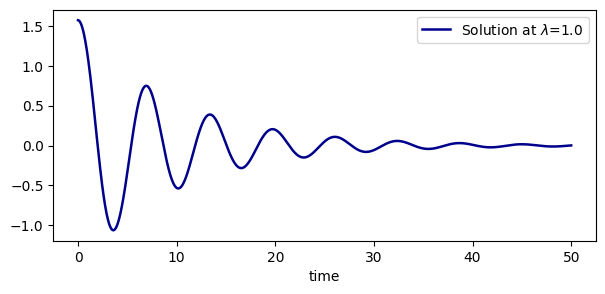

In [7]:
plt.figure(figsize=(7,3))
plt.plot(times, sol[:,0], label=f'Solution at $\lambda$={λ}', lw=1.8, color='darkblue')
plt.xlabel('time')
plt.legend()

### Building the Surrogate Model

To build a reduced model we will first need to build a reduced basis, then an empirical interpolator and finally we will build the model. So we will first import the necessary modules and build the base.

In [8]:
from skreducedmodel.reducedbasis import ReducedBasis
from skreducedmodel.empiricalinterpolation import EmpiricalInterpolation
from skreducedmodel.surrogate import Surrogate

in order of construct the reduced basis we define a discretization of the parametric domain and build a training set.

In [9]:
param = np.linspace(1,5,101)
training = []
for λ in param:
    sol = odeint(pend,y0, times, (b,λ))
    training.append(sol[:,0])

Instantiate the ReducedBasis class (in this case with default parameters) and create the reduced base. 

In [10]:
rb = ReducedBasis()

rb.fit(training_set = np.array(training),
       parameters = param,
       physical_points = times
       )

We plot some of the elements of the reduced base

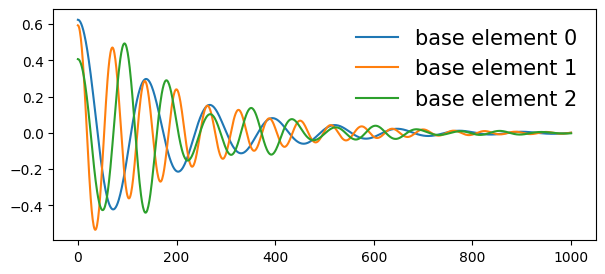

In [11]:
plt.figure(figsize=(7,3))
plt.plot(rb.tree.basis[0],label='base element 0')
plt.plot(rb.tree.basis[1],label='base element 1')
plt.plot(rb.tree.basis[2],label='base element 2')
plt.legend(fontsize=15,frameon=False)

We will now construct the empirical interpolator from our reduced base.

In [12]:
eim = EmpiricalInterpolation(rb)

eim.fit()

And finally, we build our surrogate model from our empirical interpolator.

In [13]:
model = Surrogate(eim)

model.fit()

We choose one of the parameters with which the model has not been trained, e.g. 3.42, and plot the original solution and the one predicted by our model.

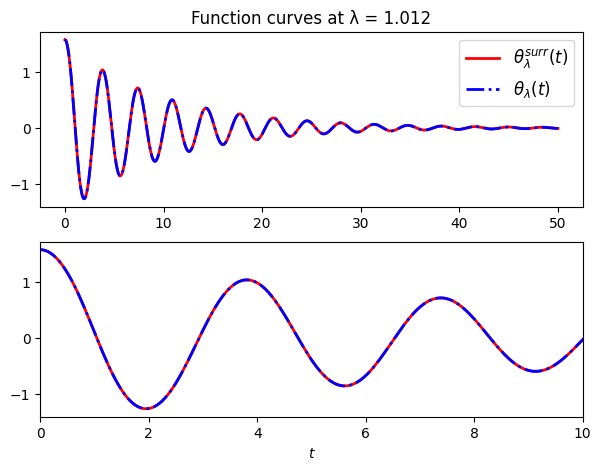

In [14]:
q = 3.42


sol = odeint(pend,y0, times, (b,q))[:,0]
fig, ax = plt.subplots(2,1, figsize=(7,5))
ax[0].plot(times, model.predict(q), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[0].plot(times, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].plot(times, model.predict(q), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[1].plot(times, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].set(xlim=(0,10))
ax[1].set(xlabel='$t$')
ax[0].set_title('Function curves at λ = 1.012')
ax[0].legend(fontsize = 'large')



### mkreducedmodel | the direct form

The above example serves to demonstrate the process of constructing surrogate models. In case you are not interested in the ReducedBasis and EmpiricalInterpolation objects and only want to work with the surrogate model, you can work directly with the mksurrogate() function:

In [15]:
from skreducedmodel.mksurrogate import mksurrogate

In [16]:
model = mksurrogate(training_set = np.array(training),
                   parameters = param,
                   physical_points = times)

Text(0.5, 0, 't')

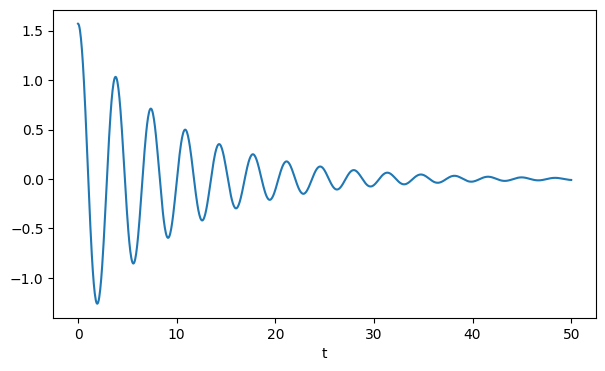

In [17]:
plt.figure(figsize=(7,4))
plt.plot(times,model.predict(q))
plt.xlabel('t')

### ReducedBasis | Domain partition

With scikit-reducedmodel we can partition the domain to allow us to build local reduced bases for each parameter. In this way we can improve the accuracy of our model. To do so, we build a binary tree structure where each leaf contains a subdomain defined by the partition. In each subdomain a reduced basis is built which, if it does not reach the user-defined "greedy_tol" accuracy, is iteratively split into two sections until all subdomains contain a reduced basis that reaches the required accuracy or the maximum depth of the tree, also defined by the user, by means of the parameter lmax.

Technical details about the algorithm and its potentials are discussed in [Cerino et. al 2022](https://arxiv.org/abs/2212.08554) , here we will show an example of how the algorithm is used in skreducedmodel.

First, we will build a model with a greedy_tol accuracy defined by the user, with a nmax maximum number of elements of the base and without domain partitioning (lmax = 0). 

In [25]:
model = mksurrogate(greedy_tol = 1e-10,
                    lmax = 0,
                    nmax = 8,
                    training_set = np.array(training),
                    parameters = param,
                    physical_points = times)

And then we will build a new model with the same accuracy, but with domain partitioning ( lmax >0 ).

In [24]:
model_partition = mksurrogate(greedy_tol = 1e-10,
                              lmax = 30,
                              nmax = 8,
                              training_set = np.array(training),
                              parameters = param,
                              physical_points = times)
                              

Finally, we compare the two models built with the theoretical result

Text(0.5, 0, '$t$')

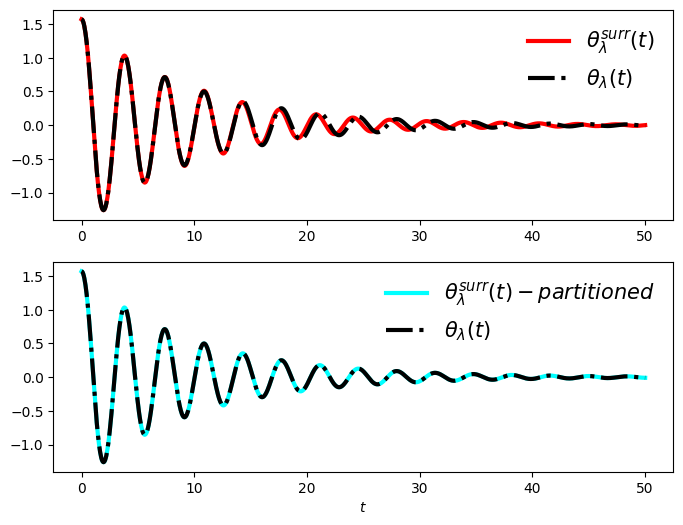

In [59]:
q = 3.42


sol = odeint(pend,y0, times, (b,q))[:,0]
plt.figure(figsize=(8,6))

plt.subplot(211)
plt.plot(times, model.predict(q), 'r', lw=3, label='$θ_λ^{surr}(t)$')
plt.plot(times, sol, 'black',ls='-.', lw=3, label='$θ_λ(t)$')
plt.legend(frameon=False,fontsize=15)

plt.subplot(212)

plt.plot(times, model_partition.predict(q), 'cyan', lw=3, label='$θ_λ^{surr}(t)-partitioned$')
plt.plot(times, sol, 'black',ls='-.', lw=3, label='$θ_λ(t)$')
plt.legend(frameon=False,fontsize=15)


plt.xlabel('$t$')

It can be seen in the figure how in the case of the model with domain partitioning the prediction is more correct than in the case without partitioning. It should be noted that this is not always the case, as the maximum accuracy depends not only on the partitions, but also on the greedy_tol and the desired nmax. (for detail see: [Cerino et. al 2022](https://arxiv.org/abs/2212.08554))